In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from pathlib import Path 

%matplotlib inline


In [8]:
def load_data(dir_list,image_size):
    """
    Read images, resize and normalize them. 
    """
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory): 
            # load the image
            image = cv2.imread(directory+'//'+filename)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            if directory[-7:] == 'AD_crop':#directory[-6:]
                y.append([2])
            elif directory[-7:] =='MI_crop':
                y.append([1])
            else:
                y.append([3])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


In [9]:
IMG_WIDTH, IMG_HEIGHT = (32,32)

X, y = load_data(['MI_crop','CN_crop','AD_crop'],(IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 2934
X shape is: (2934, 32, 32, 3)
y shape is: (2934, 1)


In [10]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam, SGD

In [11]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))


number of training examples = 2053
number of development examples = 441
number of test examples = 440
X_train shape: (2053, 32, 32, 3)
Y_train shape: (2053, 1)
X_val (dev) shape: (441, 32, 32, 3)
Y_val (dev) shape: (441, 1)
X_test shape: (440, 32, 32, 3)
Y_test shape: (440, 1)


In [15]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"



In [9]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    
    return score


In [16]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

layers =  tf.keras.layers
models = tf.keras.models

In [17]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3

    x = layers.Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = layers.Activation('relu', name=s_id + relu + sq1x1)(x)

    left = layers.Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = layers.Activation('relu', name=s_id + relu + exp1x1)(left)

    right = layers.Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = layers.Activation('relu', name=s_id + relu + exp3x3)(right)

    x = layers.concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

def SqueezeNet(input_shape=(32,32,3),classes=10):

    img_input = layers.Input(shape=input_shape)


    x = layers.Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = layers.Activation('relu', name='relu_conv1')(x)
#     x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = layers.Dropout(0.5, name='drop9')(x)

    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Activation('softmax', name='loss')(x)

    model = models.Model(img_input, out, name='squeezenet')

    return model


In [18]:
#model = build_model(IMG_SHAPE)
model =SqueezeNet()
model.build(input_shape = (None,32,32,3))
model.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2/squeeze1x1 (Conv2D)       (None, 15, 15, 16)   1040        relu_conv1[0][0]                 
_________________________________________________________________________________________

In [19]:

#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])






In [13]:
log_file_name = f'alzheimer_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')


In [14]:
#filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
i=1
filepath="cnn-parameters-improvement{i}"
i=i+1
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))


In [20]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=16, epochs=100, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/100
129/129 [==============================] - 15s 92ms/step - loss: 1.2573 - accuracy: 0.3346 - val_loss: 1.1019 - val_accuracy: 0.3447
Epoch 2/100
129/129 [==============================] - 11s 86ms/step - loss: 1.1313 - accuracy: 0.3478 - val_loss: 1.1288 - val_accuracy: 0.3084
Epoch 3/100
129/129 [==============================] - 11s 86ms/step - loss: 1.1238 - accuracy: 0.3332 - val_loss: 1.1044 - val_accuracy: 0.3469
Epoch 4/100
129/129 [==============================] - 11s 87ms/step - loss: 1.1200 - accuracy: 0.3205 - val_loss: 1.1086 - val_accuracy: 0.3469
Epoch 5/100
129/129 [==============================] - 11s 88ms/step - loss: 1.1182 - accuracy: 0.3444 - val_loss: 1.1156 - val_accuracy: 0.3447
Epoch 6/100
129/129 [==============================] - 11s 87ms/step - loss: 1.1153 - accuracy: 0.3356 - val_loss: 1.1083 - val_accuracy: 0.3469
Epoch 7/100
129/129 [==============================] - 11s 88ms/step - loss: 1.1157 - accuracy: 0.3293 - val_loss: 1.1108 - val_ac

In [21]:
history = model.history.history

In [22]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [24]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_accuracy = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

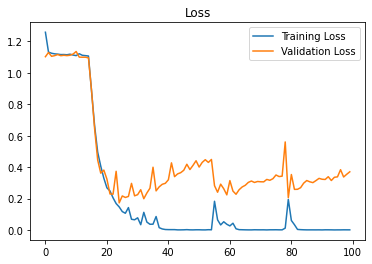

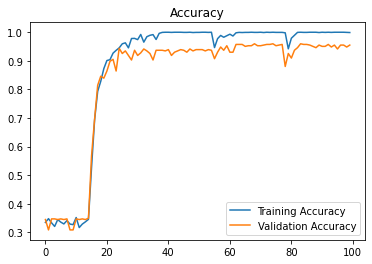

In [25]:
plot_metrics(history)

In [26]:
model.metrics_names

['loss', 'accuracy']

In [27]:
loss, acc = model.evaluate(x=X_test, y=y_test)


14/14 [==============================] - 1s 40ms/step - loss: 0.3929 - accuracy: 0.9318


In [28]:
print (f"Loss = {loss*100}")
print (f"Accuracy= {acc*100}")

Loss = 39.28627669811249
Accuracy= 93.18181872367859


In [29]:
loss, acc = model.evaluate(x=X_val, y=y_val)
print (f"Loss = {loss*100}")
print (f"Accuracy= {acc*100}")

14/14 [==============================] - 1s 41ms/step - loss: 0.3704 - accuracy: 0.9546
Loss = 37.04332709312439
Accuracy= 95.46485543251038
